# Uplift modeling introduction with example
Stephen Klosterman

steve.klosterman@gmail.com

In [65]:
# load in packages
from itertools import combinations

from test_results import valid_results, test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from sklearn.metrics import auc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# Intro
### What is it?
Uplift modeling is a predictive modeling approach to identifying which customers are most likely to response to a promotion. This modeling technique goes by several names, including net lift and incremental response modeling.

### Why do it?
Uplift modeling is useful any time there is consideration of offering a costly action, in hopes of some benefit. In marketing, this is often thought of as a coupon that might be offered. The coupon has a cost in the form of the lost revenue, due to the offerred discount. However, if the offer convinces certain customers to make the purchase, who otherwise wouldn't have, it may be worth it. __Identifying these incremental customers is the goal of uplift modeling.__

In general customers can be broken in to four groups, in terms of their behavior under the scenario of receiving a promotion. If the promotion is called a "treatment" and the desired behavior is a purchase, the situation can be visualized like this:

<img src="https://storage.googleapis.com/wf-blogs-engineering-media/2018/10/e45e2d97-confmatrix_alt.png" alt="Drawing" style="width: 400px;"/>

[Yi and Frost, 2018](https://tech.wayfair.com/data-science/2018/10/pylift-a-fast-python-package-for-uplift-modeling)

Uplift modeling seeks to identify the "persuadables" and avoid bothering the "sleeping dogs", or those who would react negatively to the action, if they exist.

### Connections to A/B testing
Building an uplift model requires a specific type of data: data from a randomized experiment, often called an A/B test if only one treatment is considered.

>Estimating customer uplift is both a Causal Inference and a Machine Learning problem. It is a causal inference problem because one needs to estimate the difference between two outcomes that are mutually exclusive for an individual (either person i receives a promotional e-mail or does not receive it). To overcome this counter-factual nature, uplift modeling crucially relies on randomized experiments, i.e. the random assignment of customers to either receive the treatment (the treatment group) or not (the control group). Uplift modeling is also a machine learning problem as one needs to train different models and select the one that yields the most reliable uplift prediction according to some per- formance metrics. This requires sensible cross-validation strategies along with potential feature engineering.

[Gutierrez and Gerardy, 2016](http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)

The results of an A/B test, such as offering a promotion, should indicate that the action has the desired effect, such as increasing sales. Once this has been established, an uplift model can be built to make a data-driven decision of __which customers to take the action on__, as opposed to the naive approach of taking a potentially costly action for all customers.

### Why does it matter at Tala?
Use cases at Tala potentially include deciding which customers to place collections phone calls to. These phone calls have some cost to Tala, in the form of call center operations. The desired benefit is that more customers will repay their loans, as a result of receiving a collections phone call. Other potential use cases include any costly offer or intervention, expected to increase revenue in some way.

### Example
These data come from a Starbucks data challenge, communicated via a Nanodegree in data science from Udacity, and then via a [blog post](https://medium.com/datadriveninvestor/simple-machine-learning-techniques-to-improve-your-marketing-strategy-demystifying-uplift-models-dc4fb3f927a2)

- `ID` = customer ID
- `Promotion` = Yes or No, did the customer receive a promotion
- `purchase` = 1 or 0, did the customer make a purchase
- `V1` - `V7` = features

The goal is to create a model to maximize incremental profit from selectively offering the promotion, which has a cost. There are specific goals laid out in the data challenge but here I will use evaluation metrics from a publication: http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf

In [2]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [3]:
test_data = pd.read_csv('./Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41650 entries, 0 to 41649
Data columns (total 10 columns):
ID           41650 non-null int64
Promotion    41650 non-null object
purchase     41650 non-null int64
V1           41650 non-null int64
V2           41650 non-null float64
V3           41650 non-null float64
V4           41650 non-null int64
V5           41650 non-null int64
V6           41650 non-null int64
V7           41650 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 3.2+ MB


# TBD: Do an a/b test assessment
Just need p-value, or also consider statistical power?

# Build model with transformed target
Single-model approach, either using encoding from blog post, or one from paper. May be good to compare them.

In [6]:
train_data['Promotion'].value_counts()
# Yes    42364
# No     42170

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [7]:
train_data['purchase'].value_counts()
# 0    83494
# 1     1040

0    83494
1     1040
Name: purchase, dtype: int64

In [8]:
train_data['Promotion'].str.match('Yes')

0        False
1        False
2        False
3        False
4         True
         ...  
84529    False
84530     True
84531    False
84532    False
84533    False
Name: Promotion, Length: 84534, dtype: bool

Make transformed target for training data. This was suggested in the blog post. It uses all the observations, to be trained in one model. The target variable is 1 if the person was offered the promotion and made the purchase, and 0 otherwise.

In [9]:
train_data['target'] = train_data['Promotion'].str.match('Yes') & train_data['purchase'].astype('bool')

# train_data['target'] = (train_data['Promotion'].str.match('Yes') & train_data['purchase'].astype('bool'))\
#     | (train_data['Promotion'].str.match('No') & train_data['purchase']==0)

train_data['target'] = train_data['target'].astype('bool')

In [10]:
train_data['target'].value_counts()
# False    83813
# True       721

False    83813
True       721
Name: target, dtype: int64

In [11]:
train_data['target'].sum()
# 721

721

In [12]:
# split training data into train and validation
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

Downsample training data for balanced classes

https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas

In [13]:
train['target'].value_counts()
# False    67047
# True       580

False    67047
True       580
Name: target, dtype: int64

In [14]:
downsampled_train = \
train.groupby('target', group_keys=False).apply(lambda x: x.sample(train['target'].sum(), random_state=1))

In [15]:
downsampled_train.shape
# (1160, 11)

(1160, 11)

In [16]:
type(downsampled_train)

pandas.core.frame.DataFrame

In [17]:
downsampled_train['target'].value_counts()
# True     580
# False    580

True     580
False    580
Name: target, dtype: int64

### Train XGBoost

In [18]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [19]:
X_train_downsamp = downsampled_train[features]
y_train_downsamp = downsampled_train['target']
X_valid = valid[features]
y_valid = valid['target']

In [20]:
eval_set = [(X_train_downsamp, y_train_downsamp), (X_valid, y_valid)]

***Maybe do any kind of hyperparameter search? With the default parameters used for the example, the first several top scores are the same, which seems a little strange.

In [21]:
# Train an xgboost model
model = xgb.XGBClassifier(learning_rate = 0.1,
                          max_depth = 7,
                          min_child_weight = 5,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)

In [22]:
%%time
model.fit(X_train_downsamp, y_train_downsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.740039	validation_1-auc:0.609996
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.751833	validation_1-auc:0.625492
[2]	validation_0-auc:0.756189	validation_1-auc:0.629561
[3]	validation_0-auc:0.758218	validation_1-auc:0.629651
[4]	validation_0-auc:0.764927	validation_1-auc:0.631139
[5]	validation_0-auc:0.771283	validation_1-auc:0.632887
[6]	validation_0-auc:0.773246	validation_1-auc:0.635403
[7]	validation_0-auc:0.774764	validation_1-auc:0.638418
[8]	validation_0-auc:0.775724	validation_1-auc:0.638948
[9]	validation_0-auc:0.780788	validation_1-auc:0.638842
[10]	validation_0-auc:0.783239	validation_1-auc:0.638794
[11]	validation_0-auc:0.788429	validation_1-auc:0.642171
[12]	validation_0-auc:0.789997	validation_1-auc:0.641225
[13]	validation_0-auc:0.793078	validation_1-auc:0.639637
[14]	validation_0-auc:0.795525	validation_1-auc:0.64065

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=2,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

Results from running at home:
```
Stopping. Best iteration:
[11]	validation_0-auc:0.788429	validation_1-auc:0.642171

CPU times: user 632 ms, sys: 29.7 ms, total: 661 ms
Wall time: 384 ms
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=2,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)
```

Identical results, running in the office.

# Model evaluation
### Uplift decile chart
Use deciles and Qini curve.
- Compare downsampling versus SMOTE, and two different ways of encoding the response

Either way, a key consideration when assessing the lift, or incremental profit, is to not use balanced (or downsampled) data, but rather to use all observations, of either the validation or test set.

Gutierrez and and Gerardy 2016:

>A common approach to evaluate an uplift model is to first predict uplift for both treated and control observations and compute the average prediction per decile in both groups. Then, the difference between those averages is taken for each decile. This difference thus gives an idea of the uplift gain per decile.

Break this procedure down in to chunks. First,

> predict uplift for both treated and control observations

Do this for the validation set.

Get uplift prediction for all observations

In [23]:
# #Peak at test set
# X_valid = test_data[features]

(array([ 731., 1248., 1984., 2305., 1922., 2370., 2119., 1953., 1332.,
         943.]),
 array([0.20156759, 0.2541693 , 0.30677098, 0.35937268, 0.41197437,
        0.46457607, 0.51717776, 0.56977946, 0.62238115, 0.67498285,
        0.72758454], dtype=float32),
 <a list of 10 Patch objects>)

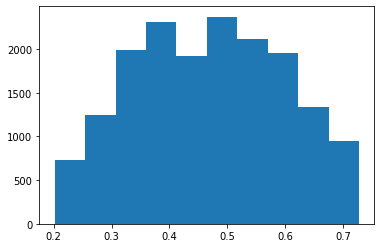

In [24]:
valid_predict_proba = model.predict_proba(X_valid)[:,1]
plt.hist(valid_predict_proba)

> compute the average prediction per decile in both groups

Need to compute deciles for each group separately, then get the mean model prediction within these groups.

I think this is actually a typo in the paper, as this would be characterizing the scores within difference deciles of scores, notwithstanding the success of the campaign (`purchase`). Rather, I think it should be to "compute the average success, per decile of predicted success, in both groups.

***Contact authors to confirm? Rather just state that I've done an evaluation oriented toward model performance in production, as opposed to analyzing model scores in and of themselves.

In [25]:
valid_predict_proba.shape

(16907,)

In [26]:
valid.shape

(16907, 11)

In [27]:
# test_data.shape

Create a new datafrmae from the validation df, to add the uplift scores and deciles to.

In [28]:
# valid_w_score = test_data.copy()
valid_w_score = valid.copy()
valid_w_score['Uplift score'] = valid_predict_proba

In [29]:
valid_w_score['Promotion'].value_counts()
# No     8474
# Yes    8433

No     8474
Yes    8433
Name: Promotion, dtype: int64

In [30]:
validation_treatment_mask = valid_w_score['Promotion'].str.match('Yes')

Make labels for the deciles. Do treatment and control groups together.

In [31]:
decile_labels = [number for number in range(1,11)]
print(decile_labels)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Pandas has a convenient function to produce a series of labels according to which quantile an observation in the input series belongs to. Get the series for treatment and control separately.

In [32]:
score_deciles, score_decile_bins = \
pd.qcut(x=valid_w_score['Uplift score'],
        q=10,
        labels=decile_labels,
        retbins=True)

Here are the quantile labels (not differentiable between treatment and control in this output):

In [33]:
score_deciles.head()

6264     8
41822    9
8569     6
41228    7
24896    4
Name: Uplift score, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

Bin edges:

In [34]:
score_decile_bins

array([0.20156759, 0.29423583, 0.34919083, 0.38772139, 0.42448917,
       0.47045654, 0.50582469, 0.55224079, 0.59514534, 0.64335269,
       0.72758454])

Doing things this way, using one set of decile bins for both control and treatment, it seems to check that the number of treated and control observations within decile bins are similar.

In [35]:
valid_w_score['Decile bin'] = score_deciles

In [36]:
valid_w_score.groupby(['Decile bin', 'Promotion'])['Promotion'].count()

Decile bin  Promotion
1           No           882
            Yes          811
2           No           837
            Yes          853
3           No           859
            Yes          847
4           No           830
            Yes          873
5           No           866
            Yes          796
6           No           853
            Yes          840
7           No           835
            Yes          869
8           No           827
            Yes          859
9           No           880
            Yes          810
10          No           805
            Yes          875
Name: Promotion, dtype: int64

These indeed look very similar.

In [37]:
valid_w_score[['Promotion', 'Decile bin', 'Uplift score', 'purchase']].head(10)

,Promotion,Decile bin,Uplift score,purchase
6264,Yes,8,0.557656,0
41822,No,9,0.618133,0
8569,No,6,0.501890,0
41228,No,7,0.523865,0
24896,Yes,4,0.413907,0
45830,Yes,3,0.356000,0
61302,Yes,3,0.386093,0
60120,Yes,10,0.661588,0
75899,No,6,0.500598,0
67557,No,2,0.340484,0


Now do a groupby/mean of the purchase occurrence to get the rate of purchase within each decile. Need to do this separately for treatment and control groups.

In [38]:
mean_response_treatment = valid_w_score[validation_treatment_mask].groupby('Decile bin')['purchase'].mean()
mean_response_control = valid_w_score[~validation_treatment_mask].groupby('Decile bin')['purchase'].mean()

In [39]:
mean_response_treatment

Decile bin
1     0.004932
2     0.005862
3     0.008264
4     0.011455
5     0.021357
6     0.017857
7     0.021864
8     0.015134
9     0.029630
10    0.030857
Name: purchase, dtype: float64

In [40]:
mean_response_control

Decile bin
1     0.010204
2     0.008363
3     0.008149
4     0.009639
5     0.003464
6     0.009379
7     0.009581
8     0.009674
9     0.006818
10    0.003727
Name: purchase, dtype: float64

> the difference between those averages is taken for each decile

Finally calculate the lift by subtracting these.

In [41]:
lift = mean_response_treatment - mean_response_control
lift

Decile bin
1    -0.005272
2    -0.002502
3     0.000115
4     0.001816
5     0.017893
6     0.008478
7     0.012283
8     0.005460
9     0.022811
10    0.027130
Name: purchase, dtype: float64

Text(0.5, 1.0, 'Difference in purchase rate\nbetween uplift score deciles of treatment and control group')

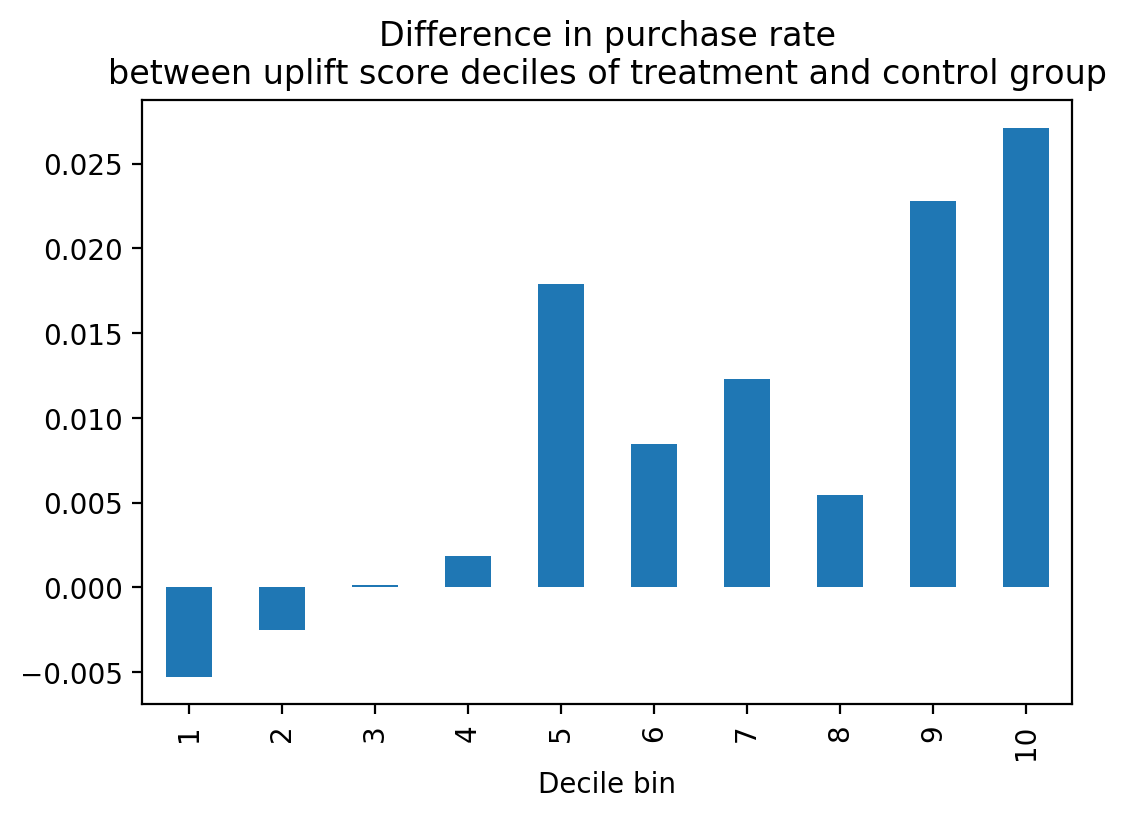

In [42]:
mpl.rcParams['figure.dpi'] = 200
lift.plot.bar()
plt.title('Difference in purchase rate\nbetween uplift score deciles of treatment and control group')

The lifts in these various deciles would, I think, be compared to the difference in purchase rates between all people who got the promotion and all who didn't, which would be the result of randomly offering the promotion to everyone.

In [43]:
purchase_rate_by_promotion = valid.groupby('Promotion')['purchase'].mean()
purchase_rate_by_promotion

Promotion
No     0.007907
Yes    0.016720
Name: purchase, dtype: float64

In [44]:
purchase_rate_by_promotion[1] - purchase_rate_by_promotion[0]

0.00881349081506308

A cumulative curve or related metric, as described in the reference, seems like a good way to get at how much lift would be obtained by targeting people starting with the highest lift scores and proceeding down. Layering on a financial component to this would be great.

Following the other evaluation approaches described Gutierrez and Gerardy,

## Cumulative uplift decile chart

In [45]:
decile_labels[::-1]

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

This indexing `[::-1]` reverses a list.

In [46]:
treatment_mean = []
control_mean = []
treatment_sum = []
control_sum = []
treatment_n = []
control_n = []

for decile_countdown in decile_labels[::-1]:
    decile_list = list(range(decile_countdown,11))
    decile_mask = valid_w_score['Decile bin'].isin(decile_list)
    
    treatment_mean.append(valid_w_score.loc[validation_treatment_mask & decile_mask, 'purchase'].mean())
    control_mean.append(valid_w_score.loc[~validation_treatment_mask & decile_mask, 'purchase'].mean())
    
    treatment_sum.append(valid_w_score.loc[validation_treatment_mask & decile_mask, 'purchase'].sum())
    control_sum.append(valid_w_score.loc[~validation_treatment_mask & decile_mask, 'purchase'].sum())
    
    treatment_n.append(valid_w_score.loc[validation_treatment_mask & decile_mask, 'purchase'].count())
    control_n.append(valid_w_score.loc[~validation_treatment_mask & decile_mask, 'purchase'].count())
    

In [47]:
cumulative_lift = np.array(treatment_mean) - np.array(control_mean)

In [48]:
cumulative_lift_series = pd.Series(data=cumulative_lift, index=decile_labels[::-1], name='Cumulative lift')

In [49]:
cumulative_lift_series

10    0.027130
9     0.024926
8     0.018390
7     0.016849
6     0.015185
5     0.015671
4     0.013645
3     0.011951
2     0.010335
1     0.008813
Name: Cumulative lift, dtype: float64

Check that the final decile gives the expected lift from marketing to everyone:

In [50]:
lift_from_all = \
valid_w_score.loc[validation_treatment_mask, 'purchase'].mean()\
- valid_w_score.loc[~validation_treatment_mask, 'purchase'].mean()

lift_from_all

0.00881349081506308

Text(0.5, 1.0, 'Cumulative uplift decile chart')

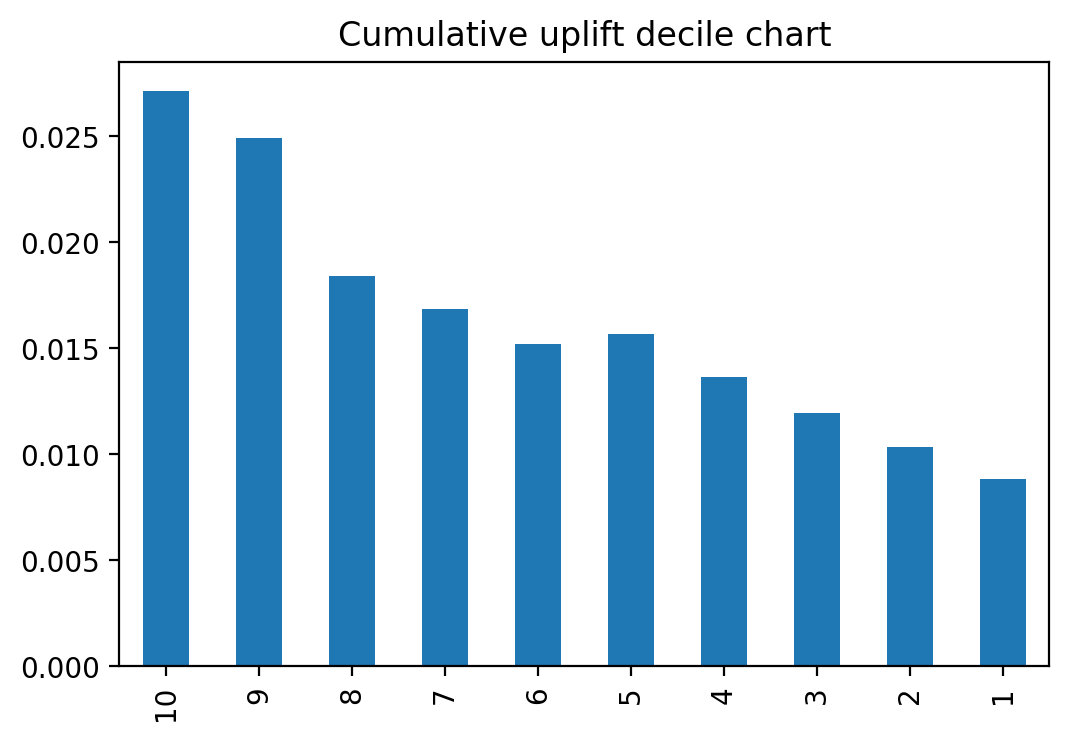

In [51]:
cumulative_lift_series.plot.bar()
plt.title('Cumulative uplift decile chart')

# Cumulative gain chart

In [52]:
cumulative_gain = \
((np.array(treatment_sum) / np.array(treatment_n))
 - (np.array(control_sum) / np.array(control_n))) \
* (np.array(treatment_n) + np.array(control_n))

In [53]:
cumulative_gain

array([ 45.57913043,  84.        ,  92.97840804, 113.90198166,
       128.36231584, 158.50801076, 161.25716907, 161.62129121,
       157.23158283, 149.00968921])

Check that the final decile is the lift, in terms of number of people, from marking to everyone.

In [54]:
lift_from_all * valid_w_score.shape[0]

149.0096892102715

In [55]:
cumulative_gain_series = \
pd.Series(data=cumulative_gain, index=decile_labels[::-1], name='Cumulative gain')

Text(0.5, 1.0, 'Cumulative gain decile chart')

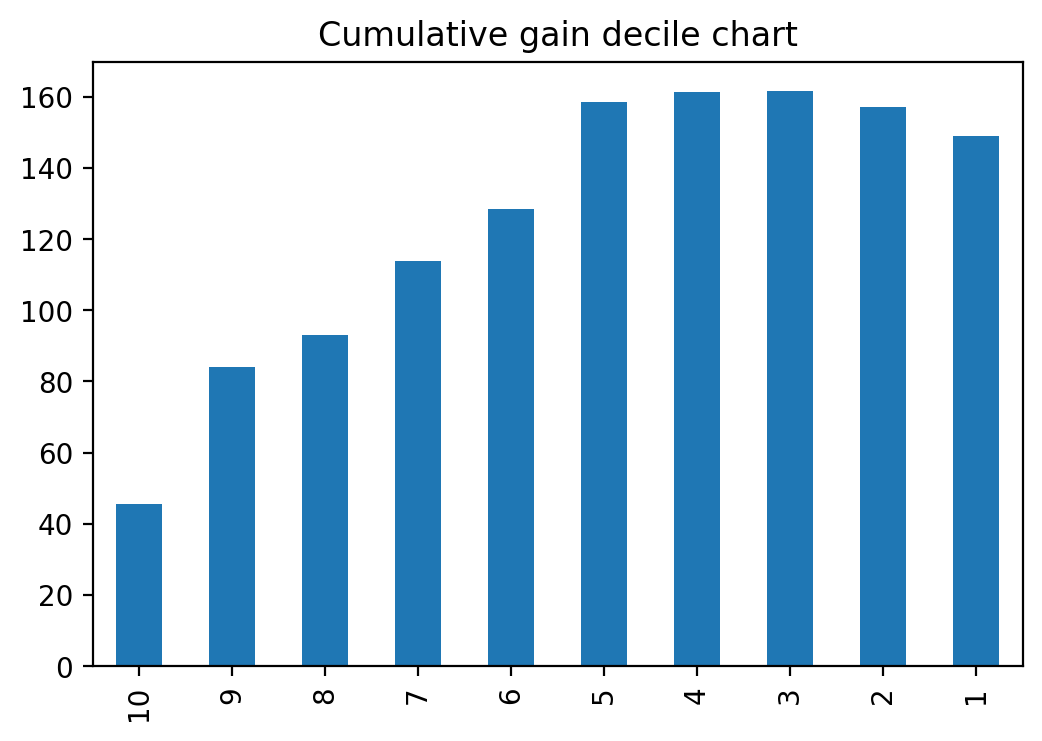

In [56]:
cumulative_gain_series.plot.bar()
plt.title('Cumulative gain decile chart')

The text states that 
>We can thus choose the decile that maximizes the gain as the limit of the population to be targeted

This seems true if finances are not considered. A probably better way to select the limit of the population to be targeted is via a cost/benefit analysis.

### Cumulative gain curve (modified Qini curve)

In [57]:
sorted_valid = valid_w_score.sort_values('Uplift score', ascending=False)
sorted_valid.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,target,Uplift score,Decile bin
63907,95205,Yes,0,2,29.866117,0.047006,2,3,4,2,False,0.727585,10
36957,54988,Yes,0,1,30.263528,-0.559039,2,3,2,2,False,0.727585,10
19234,28627,Yes,0,2,29.515353,-0.991928,2,3,4,2,False,0.727585,10
74824,111658,No,0,0,30.091188,-0.039572,2,3,1,2,False,0.727585,10
79710,118964,No,0,1,30.346373,-0.732194,2,3,1,1,False,0.727585,10


In [58]:
(sorted_valid.iloc[0:4,:]['Promotion'] == 'Yes').sum()

3

In [59]:
sorted_valid.shape

(16907, 13)

In [60]:
%%time
y_t = []
y_c = []
n_t = []
n_c = []
gain_curve = []
for row_ix in range(sorted_valid.shape[0]):
    y_t.append(
        ((sorted_valid.iloc[0:row_ix,:]['Promotion'] == 'Yes') &
         (sorted_valid.iloc[0:row_ix,:]['purchase'] == 1)).sum()
    )
    y_c.append(
        ((sorted_valid.iloc[0:row_ix,:]['Promotion'] == 'No') &
         (sorted_valid.iloc[0:row_ix,:]['purchase'] == 1)).sum()
    )
    n_t.append((sorted_valid.iloc[0:row_ix,:]['Promotion'] == 'Yes').sum())
    n_c.append((sorted_valid.iloc[0:row_ix,:]['Promotion'] == 'No').sum())
    
    gain_curve.append( ((y_t[-1]/n_t[-1]) - (y_c[-1]/n_c[-1])) * (n_t[-1] + n_c[-1]) )
    
    if row_ix % 1000 == 0:
        print(row_ix)
#Wall time: 1min 49s at home

/Users/stephen.klosterman/Documents/Virtual_Envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
CPU times: user 1min 31s, sys: 215 ms, total: 1min 32s
Wall time: 1min 32s


Probably a divide by zero error early on.

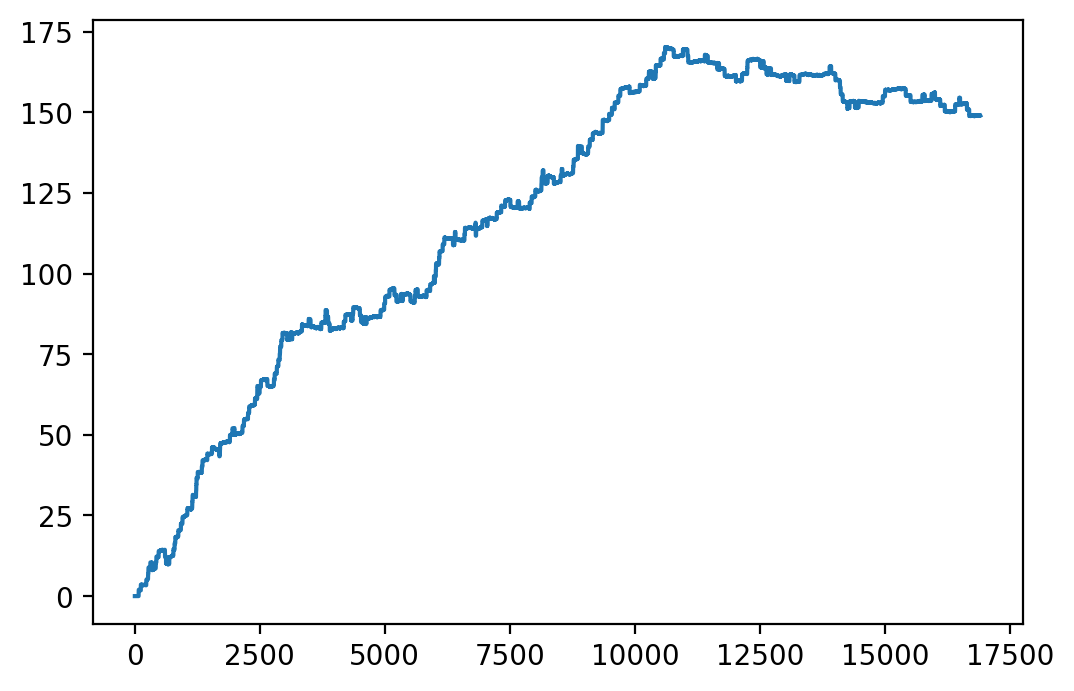

In [61]:
plt.plot(gain_curve)

Neat. All the evidence here points to there not being a particularly strong sleeping dog effect in this data set.

### Area under the gain curve
The area under the gain curve can be calculated from as a general indicator of the performance of an uplift model. This can be compared between different modeling approaches, similar how the area under the ROC curve is commonly used for binary classifiers.

Get rid of the first few NaNs.

In [86]:
gain_curve[:8]

array([nan, nan, nan, nan,  0.,  0.,  0.,  0.])

In [87]:
auc(x=range(len(gain_curve[4:])), y = gain_curve[4:])

1989093.426401922

This is not necessarily interpretable by itself, as the AUC of the ROC is, but it could be used to compare models.

### Cost benefit analysis

A more financially relevant way to determine the effect of the model on business operations is a cost-benefit analysis. This may or may not indicate the same number of customers to send the promotion to, as the financially unaware Qini curve.

A simple way to do this would be to look at the profit (revenue minus cost) of targeting the top n scorers in the validation set. If we assume the revenue of a sale is \\$10 and the cost of offering the promotion is \\$0.25 (note I chose a larger cost than the //$0.15 in the data challenge because it creates a clearer optimization), we can find the optimal number of people to target by using the results from the gain curve.

Given the variables created above, we can calcuate profit as follows:

In [62]:
revenue = (np.array(y_t) + np.array(y_c)) * 10
cost = np.array(n_t) * 0.25
profit = revenue - cost

Text(0, 0.5, 'Profit ($)')

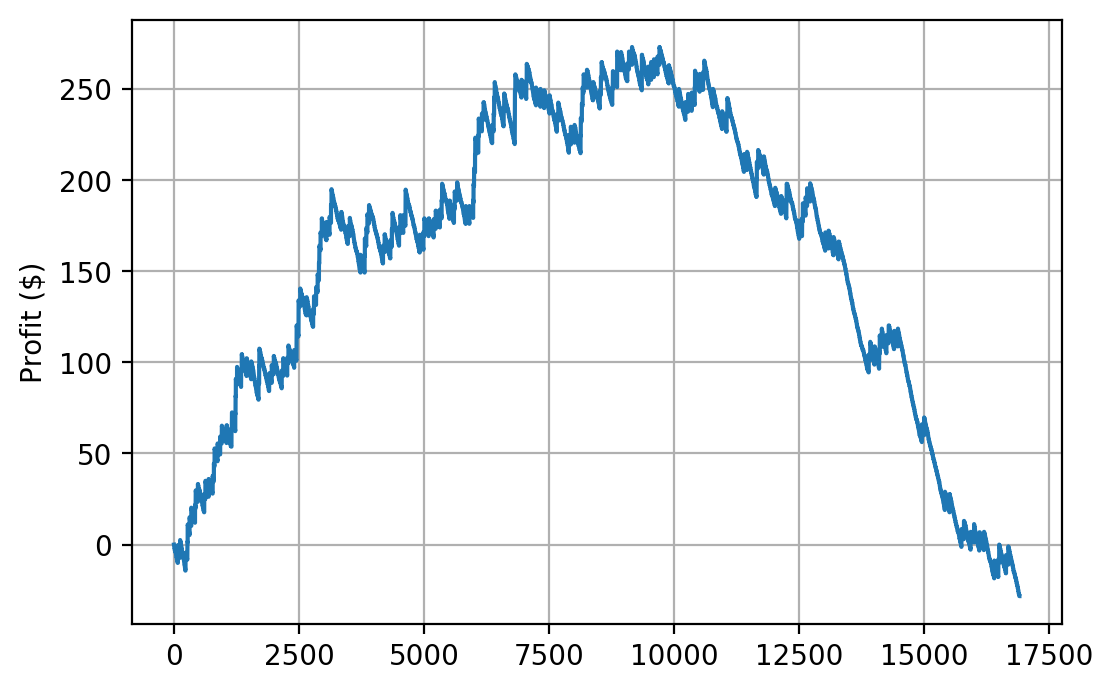

In [63]:
plt.plot(profit)
plt.grid()
plt.ylabel('Profit ($)')

It appears that the procedure of ranking people on their uplift score, then offering promotions to the highest scorers, is profitable up to about XXX people. Beyond that, the cost of the promotion outweighs the chances of purchase.

Other financial analysis methods include determining the incremental revenue

# Feature selection

In this contrived example, we were presented with a small number of explanatory variables and performed no feature selection. In reality, feature selection is an important part of the predictive modeling workflow.

The target encoding used above simplifies the task of feature selection, since the binary classification model (e.g. XGBoost) can be used to rank features in terms of feature important, or mean absolute SHAP value.

When not using an encoding such as this, for example in the two-model approach, a more standard method for variable prescreening in uplift modeling builds on the concepts of weight of evidence (WOE) and information value (IV). These concepts have been traditionally used to perform univariate feature selection in the context of binary classification. WOE and IV rely on binning values of predictors, so they present a unified framework to consider continuous and categorial features, as well as capturing linear and non-linear effects and handling missing values.

To extend these concepts to uplift modeling and account for the treatment effect, the techniques of net weight of evidence (NWOE) and net information value (NIV) are used (https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/, https://support.sas.com/resources/papers/proceedings13/096-2013.pdf, and possibly https://www.kaggle.com/pavansanagapati/weight-of-evidence-woe-information-value-iv or https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb)

An opportunity here is to implement NWOE and NIV in python, which does not appear to have been done (as it has been in SAS and I think R).

This would enable an independent point of comparison to feature importances or SHAPs from XGBoost above.

# Other modeling approaches
Do? Maybe just describe what it is, along with other approaches:
- Transformations to binary target, then use binary classification model
- Two models
- One model with treatment variable, which would be scored twice
- Multiclass model using the 4 classes directly, or a transformed outcome changing to a regression model
- Tree-growing algorithms designed to optimize for uplift

# Other concerns
- Multivariate testing